<!--NAVIGATION-->
< [In-Depth: Kernel Density Estimation](05.13-Kernel-Density-Estimation.ipynb) | [Contents](Index.ipynb) | [Further Machine Learning Resources](05.15-Learning-More.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.14-Image-Features.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Application: A Face Detection Pipeline

# 应用：脸部检测管道

> This chapter has explored a number of the central concepts and algorithms of machine learning.
But moving from these concepts to real-world application can be a challenge.
Real-world datasets are noisy and heterogeneous, may have missing features, and data may be in a form that is difficult to map to a clean ``[n_samples, n_features]`` matrix.
Before applying any of the methods discussed here, you must first extract these features from your data: there is no formula for how to do this that applies across all domains, and thus this is where you as a data scientist must exercise your own intuition and expertise.

本章讨论了很多的机器学习中关键的概念和算法。但是将这些概念移到真实世界应用仍然是一个挑战。真实世界数据集是充满噪声和异构的，可能缺失特征，并且数据也可能存在与一种难以映射到`[n_samples, n_features]`矩阵的结构中。在应用任何前面介绍的方法之前，你必须首先从数据中提取这些特征：这个步骤是没有公式，没有万能做法的，因此这是你作为数据科学家必须培养的直觉和经验。

> One interesting and compelling application of machine learning is to images, and we have already seen a few examples of this where pixel-level features are used for classification.
In the real world, data is rarely so uniform and simple pixels will not be suitable: this has led to a large literature on *feature extraction* methods for image data (see [Feature Engineering](05.04-Feature-Engineering.ipynb)).

机器学习中一个有趣和受人瞩目的领域是图像，前面我们已经举了一些这方面的例子，基本都是使用像素级的特征来进行分类。在真实世界中，数据很少能够如此规则，简单的像素也是不可能的：这导致出现了大量关于图像数据的*特征提取*方法的文献（参见[特征工程](05.04-Feature-Engineering.ipynb)）。

> In this section, we will take a look at one such feature extraction technique, the [Histogram of Oriented Gradients](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients) (HOG), which transforms image pixels into a vector representation that is sensitive to broadly informative image features regardless of confounding factors like illumination.
We will use these features to develop a simple face detection pipeline, using machine learning algorithms and concepts we've seen throughout this chapter. 

在本节中我们会看一下这种特征提取技巧，称为[方向梯度直方图](https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients)（HOG），它将图像像素转换成一个向量表示，这个向量表示形式对于广泛的图像特征信息敏感，而不会收到混杂信息例如明亮度的影响。我们将会使用这些特征开发一个简单的脸部检测管道，当中使用了本章中学习到的机器学习算法和概念。

> We begin with the standard imports:

导入包：

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## HOG Features

## HOG特征

> The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images.
HOG involves the following steps:

> 1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.
2. the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
5. Construct a one-dimensional feature vector from the information in each cell.

梯度直方图是一个很直接的特征提取方法，它是从图像中识别行人的应用中发展起来的。HOG包括下面的步骤：

1. 可选的预标准化图像。这能将图像特征变现出来，并且不依赖于图像亮度的变化。
2. 使用两个过滤器对图像进行卷积处理，这两个过滤器分别对于水平和垂直亮度梯度敏感。本步骤能捕获边缘、轮廓和纹理信息。
3. 将图像切分成预定大小的块，然后计算每块图像的方向梯度直方图。
4. 在每块图像中通过和邻近块的比较对直方图进行标准化，这能进一步削弱图像明亮度的影响。
5. 在每块图像中构建一个一维特征向量。

> A fast HOG extractor is built into the Scikit-Image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:

Scikit-Learn內建了一个快速的HOG提取器，我们可以使用它快速的建立每块图像的方向梯度并将其可视化：

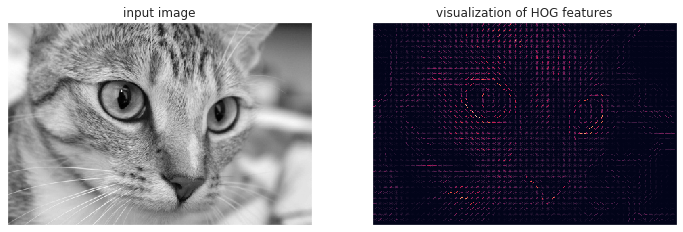

In [2]:
from skimage import data, color, feature
import skimage.data

image = color.rgb2gray(data.chelsea())
hog_vec, hog_vis = feature.hog(image, visualize=True)

fig, ax = plt.subplots(1, 2, figsize=(12, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

## HOG in Action: A Simple Face Detector

## HOG实战：一个简单的脸部检测器

> Using these HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator; here we will use a linear support vector machine (refer back to [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) if you need a refresher on this).
The steps are as follows:

> 1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples.
3. Extract HOG features from these training samples.
4. Train a linear SVM classifier on these samples.
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
6. If detections overlap, combine them into a single window.

使用这些HOG特征，我们可以使用Scikit-Learn品鼓起构建一个简单的脸部检测算法；下面我们会使用线性支持向量机（复习参见[深入：支持向量机](05.07-Support-Vector-Machines.ipynb)）。算法的步骤如下：

1. 获取一系列脸部缩略图像来组成“正”训练样本。
2. 获取一系列不含脸部的缩略图想来组成“负”训练样本。
3. 从这些训练样本中提取HOG特征。
4. 在这些样本上训练一个线性SVM分类器。
5. 对于一张“未知”图像，使用一个滑动窗口扫描图像，使用模型来计算该窗口中是否包含脸部。
6. 如果检测到重叠，将它们合并成单个窗口。

> Let's go through these steps and try it out:

下面我们一步一步来实现算法并测试效果：

### 1. Obtain a set of positive training samples

### 1. 获得一系列正训练样本

> Let's start by finding some positive training samples that show a variety of faces.
We have one easy set of data to work with—the Labeled Faces in the Wild dataset, which can be downloaded by Scikit-Learn:

让我们首先找一些正训练样本内含不同的脸部图像。我们之前使用的Wild数据集中就有这样的带标签图像，可以使用Scikit-Learn进行下载：

In [3]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people()
positive_patches = faces.images
positive_patches.shape

(13233, 62, 47)

> This gives us a sample of 13,000 face images to use for training.

这能提供我们13000张脸部图像来进行训练。

### 2. Obtain a set of negative training samples

### 2. 获得一系列负训练样本

> Next we need a set of similarly sized thumbnails which *do not* have a face in them.
One way to do this is to take any corpus of input images, and extract thumbnails from them at a variety of scales.
Here we can use some of the images shipped with Scikit-Image, along with Scikit-Learn's ``PatchExtractor``:

然后我们需要一系列的相似大小的缩略图其中不含有任何脸部图像。一个简单的办法是使用任何的输入图像集，然后从这些不同大小的图像中提取缩略图。下面我们会使用Scikit-Learn自带的一些图像，然后通过Scikit-Learn的`PatchExtractor`来提取缩略图：

In [4]:
from skimage import data, transform

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)())
          for name in imgs_to_use]

In [5]:
from sklearn.feature_extraction.image import PatchExtractor

def extract_patches(img, N, scale=1.0, patch_size=positive_patches[0].shape):
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches

negative_patches = np.vstack([extract_patches(im, 1000, scale)
                              for im in images for scale in [0.5, 1.0, 2.0]])
negative_patches.shape

(30000, 62, 47)

> We now have 30,000 suitable image patches which do not contain faces.
Let's take a look at a few of them to get an idea of what they look like:

于是我们就有了30000张不含脸部的图像作为负训练样本。下面看看其中的部分负样本图像：

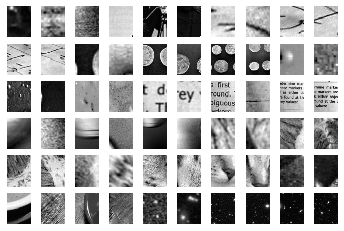

In [6]:
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(negative_patches[500 * i], cmap='gray')
    axi.axis('off')

> Our hope is that these would sufficiently cover the space of "non-faces" that our algorithm is likely to see.

我们希望这些图像足够覆盖了“不含脸部”的样本空间，能让我们的算法正常工作。

### 3. Combine sets and extract HOG features

### 3. 合并集合并提取HOG特征

> Now that we have these positive samples and negative samples, we can combine them and compute HOG features.
This step takes a little while, because the HOG features involve a nontrivial computation for each image:

获得了正样本和负样本之后，我们就能将它们合并在一起然后计算HOG特征。这一步需要较长时间，因为提取HOG特征包含了对每张图像进行复杂的计算过程：

In [7]:
from itertools import chain
X_train = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_patches)])
y_train = np.zeros(X_train.shape[0])
y_train[:positive_patches.shape[0]] = 1

In [8]:
X_train.shape

(43233, 1215)

> We are left with 43,000 training samples in 1,215 dimensions, and we now have our data in a form that we can feed into Scikit-Learn!

于是我们就有了43000个训练样本，每个样本都有1215个维度，所有的数据准备工作完成，我们可以用他们训练模型了。

### 4. Training a support vector machine

### 4. 训练支持向量机模型

> Next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches.
For such a high-dimensional binary classification task, a Linear support vector machine is a good choice.
We will use Scikit-Learn's ``LinearSVC``, because in comparison to ``SVC`` it often has better scaling for large number of samples.

下一步可以使用本章介绍的工具来创建缩略图的分类器了。对于这样一个高维两个分类的任务来说，线性支持向量机是很好的选择。我们会使用Scikit-Learn的`LinearSVC`，因为在大样本数量情况下，对比`SVC`它具有更好的扩展性。

> First, though, let's use a simple Gaussian naive Bayes to get a quick baseline:

当然首先我们会使用高斯朴素贝叶斯来获得一个基线：

In [9]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train, cv=3)

array([0.95385469, 0.97349247, 0.97501908])

> We see that on our training data, even a simple naive Bayes algorithm gets us upwards of 90% accuracy.
Let's try the support vector machine, with a grid search over a few choices of the C parameter:

上面的结果说明即使只是一个简单的朴素贝叶斯算法也能达到超过90%的准确率。下面试验支持向量机，在不同的一些C参数上使用网格搜索验证：

译者注：下面代码设置了`cv=3`以满足新版Scikit-Learn要求，添加`dual=False`压制警告输出。

In [10]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(dual=False), {'C': [1.0, 2.0, 4.0, 8.0]}, cv=3)
grid.fit(X_train, y_train)
grid.best_score_

0.9891286748548562

In [11]:
grid.best_params_

{'C': 1.0}

> Let's take the best estimator and re-train it on the full dataset:

然后使用最优的评估器并重新在这个模型上进行训练：

In [12]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

### 5. Find faces in a new image

### 5. 在新图像中寻找脸部

> Now that we have this model in place, let's grab a new image and see how the model does.
We will use one portion of the astronaut image for simplicity (see discussion of this in [Caveats and Improvements](#Caveats-and-Improvements)), and run a sliding window over it and evaluate each patch:

现在模型已经准备好了，让我们使用一张新的图像看模型工作的情况。简单起见我们会使用一张宇航员的部分照片图像（参见[注意事项和改进](#Caveats-and-Improvements)），然后使用一个滑动窗口在上面计算每个块是否包含脸部：

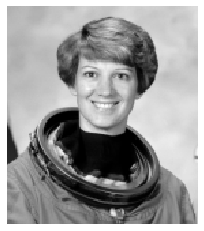

In [13]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5, multichannel=False)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

> Next, let's create a window that iterates over patches of this image, and compute HOG features for each patch:

然后让我们创建窗口并在图像上每个块上迭代计算，得到每块图像HOG特征：

In [14]:
def sliding_window(img, patch_size=positive_patches[0].shape,
                   istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(1911, 1215)

> Finally, we can take these HOG-featured patches and use our model to evaluate whether each patch contains a face:

最后，我们可以对这些HOG特征块使用前面的模型来计算里面是否包含脸部：

In [15]:
labels = model.predict(patches_hog)
labels.sum()

49.0

> We see that out of nearly 2,000 patches, we have found 30 detections.
Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

上面两个结果告诉我们有接近2000个HOG特征块，我们检测到了接近50个脸部特征。让我们将这些检测到的HOG块使用矩形绘制在测试图像之上：

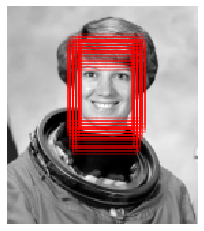

In [16]:
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = positive_patches[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.3, lw=2, facecolor='none'))

> All of the detected patches overlap and found the face in the image!
Not bad for a few lines of Python.

所有检测到HOG特征块重叠在一起并且都是检测到了图像中的脸部。仅使用了Python几行代码达到这个效果还是非常不错的。

## Caveats and Improvements

## 注意事项和改进

> If you dig a bit deeper into the preceding code and examples, you'll see that we still have a bit of work before we can claim a production-ready face detector.
There are several issues with what we've done, and several improvements that could be made. In particular:

如果你对前面代码和例子挖掘的更加深入一点，你会发现如果我们需要将这个检测器投入生产使用，还需要更多的工作。我们已经完成的部分有一些问题，也有一些改进方案可以继续实现。具体来说：

### Our training set, especially for negative features, is not very complete

### 我们的训练集，特别是负特征样本，并不全面

> The central issue is that there are many face-like textures that are not in the training set, and so our current model is very prone to false positives.
You can see this if you try out the above algorithm on the *full* astronaut image: the current model leads to many false detections in other regions of the image.

这个问题的核心是，有很多的类似脸部特征纹理的图像并没有出现在我们的训练集中，因此我们目前的模型很容易产生假阳性结果。如果使用*完整的*宇航员图像来试验上面的算法你就能发现这点：目前的模型会在图像其他区域产生很多的假阳性。

> We might imagine addressing this by adding a wider variety of images to the negative training set, and this would probably yield some improvement.
Another way to address this is to use a more directed approach, such as *hard negative mining*.
In hard negative mining, we take a new set of images that our classifier has not seen, find all the patches representing false positives, and explicitly add them as negative instances in the training set before re-training the classifier.

我们可以期望通过增加更广泛的负样本训练集图像解决这个问题，这回产生更好的结果。另外一个解决方案更加直接，被称为“硬阴性挖掘”。这个方法中我们会使用一系列分类器没见过的图像，找出其中模型检测出来的假阳性，然后明确的将这些图像块加入到负样本中重新训练分类器。

### Our current pipeline searches only at one scale

### 我们现在的管道仅能搜索一个尺度

> As currently written, our algorithm will miss faces that are not approximately 62×47 pixels.
This can be straightforwardly addressed by using sliding windows of a variety of sizes, and re-sizing each patch using ``skimage.transform.resize`` before feeding it into the model.
In fact, the ``sliding_window()`` utility used here is already built with this in mind.

如上的算法会无法检测到尺寸不是大约62×47像素的脸部图像。这可以直接通过使用不同大小的滑动窗口，然后将需检测的图像通过`skimage.transform.resize`转换成需要的大小在提供给模型进行检测。实际上我们定义的`sliding_window()`函数已经实现了这个方案。

### We should combine overlapped detection patches

### 重叠的检测区域应该被合并

> For a production-ready pipeline, we would prefer not to have 30 detections of the same face, but to somehow reduce overlapping groups of detections down to a single detection.
This could be done via an unsupervised clustering approach (MeanShift Clustering is one good candidate for this), or via a procedural approach such as *non-maximum suppression*, an algorithm common in machine vision.

对于应用到生产的算法，我们肯定不希望对同一张脸提供50个的检测结果，而是应该将这些重叠区域合并成一个检测结果。这可以通过无监督聚类方法实现（均值漂移MeanShift聚类在这个场景下是一个好选择），或者通过诸如非极大值抑制（在机器视觉领域很通用）之类的过程方法来解决。

### The pipeline should be streamlined

### 管道应该封装工程化

> Once we address these issues, it would also be nice to create a more streamlined pipeline for ingesting training images and predicting sliding-window outputs.
This is where Python as a data science tool really shines: with a bit of work, we could take our prototype code and package it with a well-designed object-oriented API that give the user the ability to use this easily.
I will leave this as a proverbial "exercise for the reader".

上面的管道代码还不够通用，如果我们能创建一个流畅管道来消化训练图像和预测滑动窗口输出的话，会更加理想。这也是Python作为数据科学工具真正闪亮的地方：只需要一点额外的工作，我们就能将我们的圆形代码封装成一个良好设计的面向对象API，为用户提供简单的接口和方便的应用。作者将这个留作“给读者的练习”。

### More recent advances: Deep Learning

### 最近的进步：深度学习

> Finally, I should add that HOG and other procedural feature extraction methods for images are no longer state-of-the-art techniques.
Instead, many modern object detection pipelines use variants of deep neural networks: one way to think of neural networks is that they are an estimator which determines optimal feature extraction strategies from the data, rather than relying on the intuition of the user.
An intro to these deep neural net methods is conceptually (and computationally!) beyond the scope of this section, although open tools like Google's [TensorFlow](https://www.tensorflow.org/) have recently made deep learning approaches much more accessible than they once were.
As of the writing of this book, deep learning in Python is still relatively young, and so I can't yet point to any definitive resource.
That said, the list of references in the following section should provide a useful place to start!

最后，作者要指出图像的HOG和其他过程特征提取方法已经不再是前沿的技术。取而代之的是更加现在的检测方式，使用不同的深度神经网络：神经网络可以被认为是一种通过数据来确定最优特征提取的评估器，而不是依赖于用户的直觉。对这些深度神经网络方法的介绍超越了本节的范围，虽然开源工具如谷歌的[TensorFlow](https://www.tensorflow.org/)最近将深度学习方法变得非常容易掌握。当编写这本书时，Python的深度学习依然比较年轻，因此作者无法提供很确定的资源。也就是说下一届的参考列表应该是作为读者起步的好地方。

<!--NAVIGATION-->
< [In-Depth: Kernel Density Estimation](05.13-Kernel-Density-Estimation.ipynb) | [Contents](Index.ipynb) | [Further Machine Learning Resources](05.15-Learning-More.ipynb) >

<a href="https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.14-Image-Features.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
